In [2]:
import os
import random
import cv2
import copy
import torch
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2.data import build_detection_train_loader, build_detection_test_loader, DatasetMapper, detection_utils
import detectron2.data.transforms as T

# Load data

In [3]:
data_dir = '/home/weiyao/data/food53'
train_json_path = data_dir + '/annotations/all_train.json'
val_json_path = data_dir + '/annotations/all_val.json'
test_json_path = data_dir + '/annotations/all_test.json'
img_dir = data_dir + '/images'
register_coco_instances("food100_supervised_train", {}, train_json_path, img_dir)
register_coco_instances("food100_supervised_val", {}, val_json_path, img_dir)
register_coco_instances("food100_supervised_test", {}, test_json_path, img_dir)

In [4]:
food100_supervised_train_metadata = MetadataCatalog.get("food100_supervised_train")
food100_supervised_train_metadata

namespace(name='food100_supervised_train',
          json_file='/home/weiyao/data/food53/annotations/all_train.json',
          image_root='/home/weiyao/data/food53/images',
          evaluator_type='coco')

In [5]:
dataset_dicts = DatasetCatalog.get("food100_supervised_train")

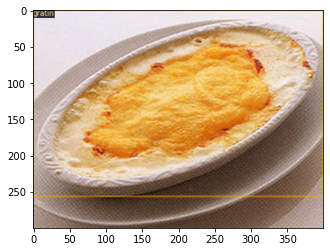

In [6]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=food100_supervised_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, :])

# Data augmentation

In [7]:
def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = detection_utils.read_image(dataset_dict["file_name"], format="BGR")

    image, transforms = T.apply_transform_gens([
        T.RandomFlip(prob=0.25, horizontal=True, vertical=False),
        T.RandomFlip(prob=0.25, horizontal=False, vertical=True),
        T.RandomApply(tfm_or_aug=T.RandomBrightness(intensity_min=0.75, intensity_max=1.25),
                      prob=0.25),
        T.RandomApply(tfm_or_aug=T.RandomContrast(intensity_min=0.76, intensity_max=1.25),
                      prob=0.25),
        T.RandomApply(tfm_or_aug=T.RandomCrop(crop_type="relative_range", crop_size=(0.5, 0.5)), 
                      prob=0.25),
        T.RandomApply(tfm_or_aug=T.RandomSaturation(intensity_min=0.75, intensity_max=1.25), 
                      prob=0.25),
        T.RandomApply(tfm_or_aug=T.RandomRotation(angle=[-60,60], expand=True, center=None, sample_style="range", interp=None), 
                      prob=0.25)

    ], image)
    
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        detection_utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = detection_utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = detection_utils.filter_empty_instances(instances)
    return dataset_dict

# Training

In [8]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("food100_supervised_train",)
cfg.DATASETS.TEST = ("food100_supervised_val",)
cfg.TEST.EVAL_PERIOD = 1000
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 50000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 53  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [9]:
trainer = MyTrainer(cfg)
#trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[11/28 14:21:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/28 14:21:58 d2.data.datasets.coco]: Loaded 1214 images in COCO format from /home/weiyao/data/food53/annotations/all_test.json
[11/28 14:21:58 d2.data.build]: Removed 0 images with no usable annotations. 1214 images left.
[11/28 14:21:58 d2.data.build]: Distribution of instances among all 53 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     rice      | 104          |   rice bowl   | 80           |  fried rice   | 73           |
|  curry bowl   | 45           |     sushi     | 17           |     toast     | 51           |
|   croissant   | 13           |     bread     | 21           |   hamburger   | 26           |
|     pizza     | 14           |  sandwiches   | 23           | noodle or r.. | 119          |
| fried noodle  | 14           |   spaghetti   | 30           | stir fry or.. | 37           |
|    omelet     | 31       

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (54, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (54,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (212, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (212,) in the model! You might want to double check if this is expected.


[11/28 14:21:58 d2.data.datasets.coco]: Loaded 1214 images in COCO format from /home/weiyao/data/food53/annotations/all_test.json
[11/28 14:21:58 d2.data.build]: Removed 0 images with no usable annotations. 1214 images left.
[11/28 14:21:58 d2.data.build]: Using training sampler TrainingSampler
[11/28 14:21:58 d2.data.common]: Serializing 1214 elements to byte tensors and concatenating them all ...
[11/28 14:21:58 d2.data.common]: Serialized dataset takes 0.30 MiB


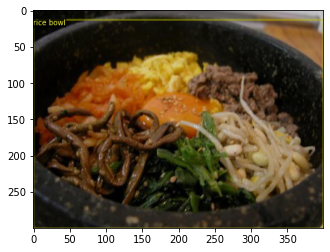

In [10]:
train_data_loader = build_detection_train_loader(cfg,mapper=mapper,sampler=None)
metadata = MetadataCatalog.get("food100_supervised_train")
for batch in train_data_loader:
    for per_image in batch:
        # Pytorch tensor is in (C, H, W) format
        img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
        img = detection_utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

        visualizer = Visualizer(img, metadata=metadata, scale=0.5)
        target_fields = per_image["instances"].get_fields()
        labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]]
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
            keypoints=target_fields.get("gt_keypoints", None),
        )
        break
    break
plt.imshow(vis.get_image()[:, :, :])
        #output(vis, str(per_image["image_id"]) + ".jpg")

In [11]:
trainer.train()

[11/28 14:21:58 d2.engine.train_loop]: Starting training from iteration 0
[11/28 14:22:02 d2.utils.events]:  eta: 2:15:01  iter: 19  total_loss: 4.123  loss_cls: 3.989  loss_box_reg: 0.1002  loss_rpn_cls: 0.008115  loss_rpn_loc: 0.008078  time: 0.1591  data_time: 0.0100  lr: 1.9981e-05  max_mem: 2612M
[11/28 14:22:05 d2.utils.events]:  eta: 2:15:21  iter: 39  total_loss: 3.407  loss_cls: 3.157  loss_box_reg: 0.1016  loss_rpn_cls: 0.005746  loss_rpn_loc: 0.008696  time: 0.1617  data_time: 0.0030  lr: 3.9961e-05  max_mem: 2612M
[11/28 14:22:08 d2.utils.events]:  eta: 2:14:35  iter: 59  total_loss: 1.219  loss_cls: 1.016  loss_box_reg: 0.099  loss_rpn_cls: 0.004727  loss_rpn_loc: 0.006996  time: 0.1599  data_time: 0.0028  lr: 5.9941e-05  max_mem: 2612M
[11/28 14:22:11 d2.utils.events]:  eta: 2:11:16  iter: 79  total_loss: 0.3237  loss_cls: 0.197  loss_box_reg: 0.1027  loss_rpn_cls: 0.002393  loss_rpn_loc: 0.01133  time: 0.1581  data_time: 0.0027  lr: 7.9921e-05  max_mem: 2612M
[11/28 14:2

[11/28 14:23:44 d2.utils.events]:  eta: 2:01:25  iter: 699  total_loss: 0.2443  loss_cls: 0.1318  loss_box_reg: 0.1025  loss_rpn_cls: 0.0002515  loss_rpn_loc: 0.004816  time: 0.1507  data_time: 0.0031  lr: 0.0006993  max_mem: 2612M
[11/28 14:23:47 d2.utils.events]:  eta: 2:01:18  iter: 719  total_loss: 0.2482  loss_cls: 0.1364  loss_box_reg: 0.09879  loss_rpn_cls: 0.0005521  loss_rpn_loc: 0.00847  time: 0.1507  data_time: 0.0031  lr: 0.00071928  max_mem: 2612M
[11/28 14:23:51 d2.utils.events]:  eta: 2:01:16  iter: 739  total_loss: 0.242  loss_cls: 0.1284  loss_box_reg: 0.1001  loss_rpn_cls: 0.0001842  loss_rpn_loc: 0.005802  time: 0.1510  data_time: 0.0031  lr: 0.00073926  max_mem: 2612M
[11/28 14:23:54 d2.utils.events]:  eta: 2:02:32  iter: 759  total_loss: 0.2561  loss_cls: 0.1397  loss_box_reg: 0.1041  loss_rpn_cls: 0.0007219  loss_rpn_loc: 0.006251  time: 0.1517  data_time: 0.0033  lr: 0.00075924  max_mem: 2612M
[11/28 14:23:57 d2.utils.events]:  eta: 2:02:47  iter: 779  total_loss

[11/28 14:25:23 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:25:23 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:25:23 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:25:23 d2.evaluation.testing]: copypaste: 1.3528,2.4538,1.3300,nan,0.0000,1.3528
[11/28 14:25:23 d2.utils.events]:  eta: 2:01:35  iter: 999  total_loss: 0.2702  loss_cls: 0.1541  loss_box_reg: 0.09708  loss_rpn_cls: 0.0001795  loss_rpn_loc: 0.005634  time: 0.1519  data_time: 0.0030  lr: 0.000999  max_mem: 2612M
[11/28 14:25:26 d2.utils.events]:  eta: 2:01:50  iter: 1019  total_loss: 0.2763  loss_cls: 0.1641  loss_box_reg: 0.1079  loss_rpn_cls: 0.0001837  loss_rpn_loc: 0.006202  time: 0.1520  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 14:25:29 d2.utils.events]:  eta: 2:00:28  iter: 1039  total_loss: 0.3045  loss_cls: 0.1744  loss_box_reg: 0.1  loss_rpn_cls: 0.0002335  loss_rpn_loc: 0.007851  time: 0.1519  data_time: 0.0032  lr: 0.001  m

[11/28 14:27:05 d2.utils.events]:  eta: 2:02:26  iter: 1659  total_loss: 0.2083  loss_cls: 0.1171  loss_box_reg: 0.06839  loss_rpn_cls: 0.0004718  loss_rpn_loc: 0.007284  time: 0.1529  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:27:08 d2.utils.events]:  eta: 2:02:03  iter: 1679  total_loss: 0.238  loss_cls: 0.1498  loss_box_reg: 0.08269  loss_rpn_cls: 0.0005815  loss_rpn_loc: 0.005125  time: 0.1529  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:27:11 d2.utils.events]:  eta: 2:02:10  iter: 1699  total_loss: 0.1574  loss_cls: 0.09977  loss_box_reg: 0.05061  loss_rpn_cls: 0.0002821  loss_rpn_loc: 0.004174  time: 0.1528  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:27:14 d2.utils.events]:  eta: 2:02:22  iter: 1719  total_loss: 0.2655  loss_cls: 0.1682  loss_box_reg: 0.08755  loss_rpn_cls: 0.0008031  loss_rpn_loc: 0.005403  time: 0.1529  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:27:17 d2.utils.events]:  eta: 2:02:04  iter: 1739  total_loss: 0.2647 

[11/28 14:28:49 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:28:49 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:28:49 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:28:49 d2.evaluation.testing]: copypaste: 4.6946,7.8738,4.9372,nan,0.0000,4.6947
[11/28 14:28:49 d2.utils.events]:  eta: 2:01:11  iter: 1999  total_loss: 0.1828  loss_cls: 0.122  loss_box_reg: 0.06054  loss_rpn_cls: 0.000605  loss_rpn_loc: 0.004852  time: 0.1528  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:28:52 d2.utils.events]:  eta: 2:00:36  iter: 2019  total_loss: 0.1863  loss_cls: 0.1189  loss_box_reg: 0.05806  loss_rpn_cls: 0.0002208  loss_rpn_loc: 0.004468  time: 0.1528  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 14:28:55 d2.utils.events]:  eta: 2:01:05  iter: 2039  total_loss: 0.2321  loss_cls: 0.1414  loss_box_reg: 0.07224  loss_rpn_cls: 0.00108  loss_rpn_loc: 0.005847  time: 0.1529  data_time: 0.0032  lr: 0.001  ma

[11/28 14:30:30 d2.utils.events]:  eta: 1:57:07  iter: 2659  total_loss: 0.1786  loss_cls: 0.1102  loss_box_reg: 0.04722  loss_rpn_cls: 0.0004582  loss_rpn_loc: 0.00505  time: 0.1527  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:30:34 d2.utils.events]:  eta: 1:57:43  iter: 2679  total_loss: 0.1707  loss_cls: 0.1129  loss_box_reg: 0.05764  loss_rpn_cls: 0.0003522  loss_rpn_loc: 0.004461  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:30:38 d2.utils.events]:  eta: 1:58:00  iter: 2699  total_loss: 0.1571  loss_cls: 0.09912  loss_box_reg: 0.04986  loss_rpn_cls: 0.0001809  loss_rpn_loc: 0.00411  time: 0.1537  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:30:41 d2.utils.events]:  eta: 1:57:24  iter: 2719  total_loss: 0.1618  loss_cls: 0.08837  loss_box_reg: 0.05053  loss_rpn_cls: 0.0008474  loss_rpn_loc: 0.004141  time: 0.1535  data_time: 0.0024  lr: 0.001  max_mem: 2612M
[11/28 14:30:44 d2.utils.events]:  eta: 1:57:28  iter: 2739  total_loss: 0.1951 

[11/28 14:32:16 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:32:16 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:32:16 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:32:16 d2.evaluation.testing]: copypaste: 12.1737,19.4875,13.2311,nan,0.0000,12.1769
[11/28 14:32:16 d2.utils.events]:  eta: 1:56:28  iter: 2999  total_loss: 0.1913  loss_cls: 0.1281  loss_box_reg: 0.0541  loss_rpn_cls: 0.0005814  loss_rpn_loc: 0.005012  time: 0.1536  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:32:19 d2.utils.events]:  eta: 1:56:32  iter: 3019  total_loss: 0.1637  loss_cls: 0.1093  loss_box_reg: 0.0505  loss_rpn_cls: 0.0004587  loss_rpn_loc: 0.004034  time: 0.1536  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:32:23 d2.utils.events]:  eta: 1:56:22  iter: 3039  total_loss: 0.1524  loss_cls: 0.0905  loss_box_reg: 0.05182  loss_rpn_cls: 0.0005775  loss_rpn_loc: 0.004921  time: 0.1536  data_time: 0.0028  lr: 0.0

[11/28 14:33:58 d2.utils.events]:  eta: 1:54:53  iter: 3659  total_loss: 0.1801  loss_cls: 0.09439  loss_box_reg: 0.05096  loss_rpn_cls: 0.0006496  loss_rpn_loc: 0.004648  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:34:01 d2.utils.events]:  eta: 1:54:00  iter: 3679  total_loss: 0.1558  loss_cls: 0.09325  loss_box_reg: 0.05115  loss_rpn_cls: 0.0002  loss_rpn_loc: 0.004778  time: 0.1535  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:34:04 d2.utils.events]:  eta: 1:53:57  iter: 3699  total_loss: 0.1846  loss_cls: 0.1097  loss_box_reg: 0.06106  loss_rpn_cls: 0.000211  loss_rpn_loc: 0.005207  time: 0.1536  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:34:07 d2.utils.events]:  eta: 1:54:10  iter: 3719  total_loss: 0.148  loss_cls: 0.09044  loss_box_reg: 0.04013  loss_rpn_cls: 0.0001975  loss_rpn_loc: 0.00521  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:34:10 d2.utils.events]:  eta: 1:54:07  iter: 3739  total_loss: 0.1844  lo

[11/28 14:35:42 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:35:42 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:35:42 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:35:42 d2.evaluation.testing]: copypaste: 16.9662,27.4955,18.1156,nan,0.0000,16.9703
[11/28 14:35:42 d2.utils.events]:  eta: 1:53:25  iter: 3999  total_loss: 0.1337  loss_cls: 0.07706  loss_box_reg: 0.05047  loss_rpn_cls: 0.0002303  loss_rpn_loc: 0.003011  time: 0.1534  data_time: 0.0026  lr: 0.001  max_mem: 2612M
[11/28 14:35:45 d2.utils.events]:  eta: 1:53:22  iter: 4019  total_loss: 0.1593  loss_cls: 0.1032  loss_box_reg: 0.04398  loss_rpn_cls: 0.000194  loss_rpn_loc: 0.004241  time: 0.1534  data_time: 0.0025  lr: 0.001  max_mem: 2612M
[11/28 14:35:48 d2.utils.events]:  eta: 1:53:30  iter: 4039  total_loss: 0.1721  loss_cls: 0.1174  loss_box_reg: 0.04728  loss_rpn_cls: 0.0002119  loss_rpn_loc: 0.005652  time: 0.1534  data_time: 0.0028  lr: 0

[11/28 14:37:23 d2.utils.events]:  eta: 1:51:37  iter: 4659  total_loss: 0.1542  loss_cls: 0.1016  loss_box_reg: 0.04428  loss_rpn_cls: 0.0001931  loss_rpn_loc: 0.004924  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:37:26 d2.utils.events]:  eta: 1:51:36  iter: 4679  total_loss: 0.14  loss_cls: 0.07525  loss_box_reg: 0.05087  loss_rpn_cls: 0.0002475  loss_rpn_loc: 0.003912  time: 0.1533  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:37:30 d2.utils.events]:  eta: 1:51:28  iter: 4699  total_loss: 0.1466  loss_cls: 0.08967  loss_box_reg: 0.0508  loss_rpn_cls: 0.0003892  loss_rpn_loc: 0.00739  time: 0.1533  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:37:32 d2.utils.events]:  eta: 1:51:24  iter: 4719  total_loss: 0.166  loss_cls: 0.1001  loss_box_reg: 0.05801  loss_rpn_cls: 8.14e-05  loss_rpn_loc: 0.004004  time: 0.1533  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:37:35 d2.utils.events]:  eta: 1:51:03  iter: 4739  total_loss: 0.1474  los

[11/28 14:39:08 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:39:08 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:39:08 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:39:08 d2.evaluation.testing]: copypaste: 23.3913,36.2349,26.6467,nan,0.0000,23.3962
[11/28 14:39:08 d2.utils.events]:  eta: 1:50:48  iter: 4999  total_loss: 0.1643  loss_cls: 0.1003  loss_box_reg: 0.04811  loss_rpn_cls: 0.0001406  loss_rpn_loc: 0.004575  time: 0.1533  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 14:39:11 d2.utils.events]:  eta: 1:50:34  iter: 5019  total_loss: 0.1643  loss_cls: 0.09011  loss_box_reg: 0.05476  loss_rpn_cls: 0.0004231  loss_rpn_loc: 0.004702  time: 0.1532  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:39:14 d2.utils.events]:  eta: 1:50:22  iter: 5039  total_loss: 0.1335  loss_cls: 0.07759  loss_box_reg: 0.04534  loss_rpn_cls: 0.000117  loss_rpn_loc: 0.005951  time: 0.1532  data_time: 0.0028  lr: 

[11/28 14:40:50 d2.utils.events]:  eta: 1:49:28  iter: 5659  total_loss: 0.1309  loss_cls: 0.07174  loss_box_reg: 0.04285  loss_rpn_cls: 0.0002828  loss_rpn_loc: 0.004921  time: 0.1533  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 14:40:53 d2.utils.events]:  eta: 1:49:16  iter: 5679  total_loss: 0.1627  loss_cls: 0.09832  loss_box_reg: 0.06219  loss_rpn_cls: 0.0003947  loss_rpn_loc: 0.004426  time: 0.1533  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:40:56 d2.utils.events]:  eta: 1:48:55  iter: 5699  total_loss: 0.1573  loss_cls: 0.07457  loss_box_reg: 0.05761  loss_rpn_cls: 0.0004523  loss_rpn_loc: 0.003956  time: 0.1532  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:40:59 d2.utils.events]:  eta: 1:49:17  iter: 5719  total_loss: 0.1518  loss_cls: 0.08054  loss_box_reg: 0.05357  loss_rpn_cls: 0.0003423  loss_rpn_loc: 0.004857  time: 0.1532  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:41:02 d2.utils.events]:  eta: 1:49:57  iter: 5739  total_loss: 0.1

[11/28 14:42:34 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:42:34 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:42:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:42:34 d2.evaluation.testing]: copypaste: 25.5367,41.3480,28.8568,nan,0.0000,25.5435
[11/28 14:42:34 d2.utils.events]:  eta: 1:48:18  iter: 5999  total_loss: 0.1496  loss_cls: 0.07975  loss_box_reg: 0.04907  loss_rpn_cls: 0.0001173  loss_rpn_loc: 0.004906  time: 0.1532  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:42:37 d2.utils.events]:  eta: 1:48:21  iter: 6019  total_loss: 0.1219  loss_cls: 0.06764  loss_box_reg: 0.04479  loss_rpn_cls: 0.0001605  loss_rpn_loc: 0.008117  time: 0.1532  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 14:42:40 d2.utils.events]:  eta: 1:48:36  iter: 6039  total_loss: 0.1367  loss_cls: 0.08607  loss_box_reg: 0.04286  loss_rpn_cls: 0.0002042  loss_rpn_loc: 0.004869  time: 0.1532  data_time: 0.0029  lr

[11/28 14:44:15 d2.utils.events]:  eta: 1:47:12  iter: 6659  total_loss: 0.1208  loss_cls: 0.06948  loss_box_reg: 0.0429  loss_rpn_cls: 0.0002227  loss_rpn_loc: 0.004785  time: 0.1531  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:44:18 d2.utils.events]:  eta: 1:47:44  iter: 6679  total_loss: 0.1391  loss_cls: 0.07141  loss_box_reg: 0.04549  loss_rpn_cls: 0.000216  loss_rpn_loc: 0.006295  time: 0.1532  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:44:21 d2.utils.events]:  eta: 1:47:34  iter: 6699  total_loss: 0.09324  loss_cls: 0.05607  loss_box_reg: 0.04162  loss_rpn_cls: 0.0003479  loss_rpn_loc: 0.00474  time: 0.1531  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:44:24 d2.utils.events]:  eta: 1:47:35  iter: 6719  total_loss: 0.1054  loss_cls: 0.05735  loss_box_reg: 0.03706  loss_rpn_cls: 0.0003364  loss_rpn_loc: 0.004973  time: 0.1531  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:44:27 d2.utils.events]:  eta: 1:47:15  iter: 6739  total_loss: 0.131

[11/28 14:46:00 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 23.681 | rice bowl          | 45.194 | fried rice                    | 34.970 |
| curry bowl                        | 46.037 | sushi              | 12.423 | toast                         | 37.130 |
| croissant                         | 24.130 | bread              | 37.715 | hamburger                     | 43.616 |
| pizza                             | 67.490 | sandwiches         | 36.454 | noodle or ramen               | 43.257 |
| fried noodle                      | 24.797 | spaghetti          | 36.927 | stir fry or boiled vegetables | 30.479 |
| omelet                            | 56.119 | dumpling           | 14.157 | stew                      

[11/28 14:47:10 d2.utils.events]:  eta: 1:45:56  iter: 7459  total_loss: 0.1352  loss_cls: 0.07067  loss_box_reg: 0.05222  loss_rpn_cls: 0.0002588  loss_rpn_loc: 0.004489  time: 0.1531  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:47:13 d2.utils.events]:  eta: 1:45:53  iter: 7479  total_loss: 0.1068  loss_cls: 0.05062  loss_box_reg: 0.04182  loss_rpn_cls: 0.0002439  loss_rpn_loc: 0.005562  time: 0.1531  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:47:17 d2.utils.events]:  eta: 1:45:58  iter: 7499  total_loss: 0.1016  loss_cls: 0.0567  loss_box_reg: 0.02902  loss_rpn_cls: 0.0005238  loss_rpn_loc: 0.005092  time: 0.1531  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 14:47:20 d2.utils.events]:  eta: 1:46:26  iter: 7519  total_loss: 0.1102  loss_cls: 0.05367  loss_box_reg: 0.04666  loss_rpn_cls: 0.0003085  loss_rpn_loc: 0.004193  time: 0.1531  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 14:47:23 d2.utils.events]:  eta: 1:46:29  iter: 7539  total_loss: 0.14

[11/28 14:49:21 d2.evaluation.evaluator]: Inference done 1084/1214. 0.0413 s / img. ETA=0:00:05
[11/28 14:49:26 d2.evaluation.evaluator]: Inference done 1203/1214. 0.0413 s / img. ETA=0:00:00
[11/28 14:49:26 d2.evaluation.evaluator]: Total inference time: 0:00:50.902435 (0.042103 s / img per device, on 1 devices)
[11/28 14:49:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:49 (0.041268 s / img per device, on 1 devices)
[11/28 14:49:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/28 14:49:26 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/28 14:49:26 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.85 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in

[11/28 14:50:06 d2.utils.events]:  eta: 1:45:03  iter: 8259  total_loss: 0.1055  loss_cls: 0.05709  loss_box_reg: 0.03441  loss_rpn_cls: 0.000164  loss_rpn_loc: 0.003805  time: 0.1532  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:50:09 d2.utils.events]:  eta: 1:44:55  iter: 8279  total_loss: 0.1193  loss_cls: 0.06604  loss_box_reg: 0.04142  loss_rpn_cls: 9.792e-05  loss_rpn_loc: 0.003352  time: 0.1532  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:50:12 d2.utils.events]:  eta: 1:44:48  iter: 8299  total_loss: 0.1397  loss_cls: 0.07608  loss_box_reg: 0.05427  loss_rpn_cls: 0.0002759  loss_rpn_loc: 0.005057  time: 0.1532  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:50:15 d2.utils.events]:  eta: 1:45:05  iter: 8319  total_loss: 0.1213  loss_cls: 0.06001  loss_box_reg: 0.03392  loss_rpn_cls: 0.0002655  loss_rpn_loc: 0.004283  time: 0.1532  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:50:18 d2.utils.events]:  eta: 1:44:50  iter: 8339  total_loss: 0.12

[11/28 14:51:55 d2.utils.events]:  eta: 1:42:01  iter: 8959  total_loss: 0.1205  loss_cls: 0.05  loss_box_reg: 0.05197  loss_rpn_cls: 0.0002536  loss_rpn_loc: 0.00432  time: 0.1534  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:51:58 d2.utils.events]:  eta: 1:42:24  iter: 8979  total_loss: 0.1058  loss_cls: 0.05395  loss_box_reg: 0.04372  loss_rpn_cls: 0.0001449  loss_rpn_loc: 0.005912  time: 0.1534  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:52:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/28 14:52:01 d2.data.datasets.coco]: Loaded 1214 images in COCO format from /home/weiyao/data/food53/annotations/all_test.json
[11/28 14:52:01 d2.data.common]: Serializing 1214 elements to byte tensors and concatenating them all ...
[11/28 14:52:01 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [11/28 14:52:01 d2.evaluation.coco_evaluation]: COCO

[11/28 14:53:06 d2.utils.events]:  eta: 1:42:36  iter: 9079  total_loss: 0.09254  loss_cls: 0.04283  loss_box_reg: 0.03433  loss_rpn_cls: 0.0004175  loss_rpn_loc: 0.004559  time: 0.1534  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 14:53:09 d2.utils.events]:  eta: 1:42:36  iter: 9099  total_loss: 0.09201  loss_cls: 0.04319  loss_box_reg: 0.0332  loss_rpn_cls: 0.0004531  loss_rpn_loc: 0.003856  time: 0.1534  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:53:12 d2.utils.events]:  eta: 1:42:51  iter: 9119  total_loss: 0.1218  loss_cls: 0.06198  loss_box_reg: 0.04564  loss_rpn_cls: 0.0004809  loss_rpn_loc: 0.004998  time: 0.1534  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 14:53:15 d2.utils.events]:  eta: 1:43:00  iter: 9139  total_loss: 0.1319  loss_cls: 0.06811  loss_box_reg: 0.04595  loss_rpn_cls: 0.0003827  loss_rpn_loc: 0.00718  time: 0.1534  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:53:19 d2.utils.events]:  eta: 1:43:07  iter: 9159  total_loss: 0.1

[11/28 14:54:54 d2.utils.events]:  eta: 1:41:24  iter: 9779  total_loss: 0.1009  loss_cls: 0.05221  loss_box_reg: 0.0428  loss_rpn_cls: 0.0001895  loss_rpn_loc: 0.003633  time: 0.1534  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:54:57 d2.utils.events]:  eta: 1:41:21  iter: 9799  total_loss: 0.09556  loss_cls: 0.04735  loss_box_reg: 0.04043  loss_rpn_cls: 0.000448  loss_rpn_loc: 0.004496  time: 0.1534  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 14:55:00 d2.utils.events]:  eta: 1:40:58  iter: 9819  total_loss: 0.08283  loss_cls: 0.04117  loss_box_reg: 0.03895  loss_rpn_cls: 0.0003305  loss_rpn_loc: 0.003258  time: 0.1534  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:55:03 d2.utils.events]:  eta: 1:41:11  iter: 9839  total_loss: 0.1213  loss_cls: 0.06613  loss_box_reg: 0.04606  loss_rpn_cls: 0.000408  loss_rpn_loc: 0.003987  time: 0.1534  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:55:07 d2.utils.events]:  eta: 1:41:26  iter: 9859  total_loss: 0.12

[11/28 14:56:21 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 14:56:21 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 14:56:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 14:56:21 d2.evaluation.testing]: copypaste: 42.8157,64.7716,49.1939,nan,30.2970,42.8354
[11/28 14:56:21 d2.utils.events]:  eta: 1:41:03  iter: 9999  total_loss: 0.1044  loss_cls: 0.04942  loss_box_reg: 0.03393  loss_rpn_cls: 0.000237  loss_rpn_loc: 0.007225  time: 0.1535  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 14:56:24 d2.utils.events]:  eta: 1:40:54  iter: 10019  total_loss: 0.1064  loss_cls: 0.04786  loss_box_reg: 0.04568  loss_rpn_cls: 0.0002227  loss_rpn_loc: 0.004382  time: 0.1534  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:56:27 d2.utils.events]:  eta: 1:41:03  iter: 10039  total_loss: 0.1152  loss_cls: 0.05279  loss_box_reg: 0.0574  loss_rpn_cls: 0.0002467  loss_rpn_loc: 0.004328  time: 0.1535  data_time: 0.0030  l

[11/28 14:58:01 d2.utils.events]:  eta: 1:37:17  iter: 10659  total_loss: 0.1043  loss_cls: 0.04462  loss_box_reg: 0.0425  loss_rpn_cls: 0.0002162  loss_rpn_loc: 0.004014  time: 0.1533  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:58:04 d2.utils.events]:  eta: 1:37:17  iter: 10679  total_loss: 0.09685  loss_cls: 0.04193  loss_box_reg: 0.04461  loss_rpn_cls: 0.0002148  loss_rpn_loc: 0.004388  time: 0.1533  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 14:58:08 d2.utils.events]:  eta: 1:37:44  iter: 10699  total_loss: 0.1114  loss_cls: 0.04641  loss_box_reg: 0.04172  loss_rpn_cls: 0.0007074  loss_rpn_loc: 0.00485  time: 0.1534  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 14:58:11 d2.utils.events]:  eta: 1:37:20  iter: 10719  total_loss: 0.1085  loss_cls: 0.05109  loss_box_reg: 0.04231  loss_rpn_cls: 0.0005533  loss_rpn_loc: 0.00449  time: 0.1534  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 14:58:14 d2.utils.events]:  eta: 1:37:38  iter: 10739  total_loss: 

[11/28 14:59:46 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 30.215 | rice bowl          | 56.332 | fried rice                    | 38.872 |
| curry bowl                        | 57.600 | sushi              | 32.715 | toast                         | 40.257 |
| croissant                         | 41.664 | bread              | 45.213 | hamburger                     | 50.062 |
| pizza                             | 75.839 | sandwiches         | 47.651 | noodle or ramen               | 53.596 |
| fried noodle                      | 51.708 | spaghetti          | 46.645 | stir fry or boiled vegetables | 41.291 |
| omelet                            | 59.378 | dumpling           | 23.525 | stew                      

[11/28 15:00:56 d2.utils.events]:  eta: 1:34:40  iter: 11459  total_loss: 0.0997  loss_cls: 0.04533  loss_box_reg: 0.04363  loss_rpn_cls: 0.0002566  loss_rpn_loc: 0.004255  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:00:59 d2.utils.events]:  eta: 1:35:01  iter: 11479  total_loss: 0.09057  loss_cls: 0.042  loss_box_reg: 0.03539  loss_rpn_cls: 0.0001718  loss_rpn_loc: 0.003605  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:01:02 d2.utils.events]:  eta: 1:34:57  iter: 11499  total_loss: 0.1347  loss_cls: 0.05608  loss_box_reg: 0.05931  loss_rpn_cls: 0.00129  loss_rpn_loc: 0.005659  time: 0.1533  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:01:05 d2.utils.events]:  eta: 1:34:28  iter: 11519  total_loss: 0.09897  loss_cls: 0.04812  loss_box_reg: 0.04424  loss_rpn_cls: 0.0003117  loss_rpn_loc: 0.003987  time: 0.1533  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:01:08 d2.utils.events]:  eta: 1:34:55  iter: 11539  total_loss: 

[11/28 15:03:04 d2.evaluation.evaluator]: Inference done 1083/1214. 0.0414 s / img. ETA=0:00:05
[11/28 15:03:09 d2.evaluation.evaluator]: Inference done 1202/1214. 0.0414 s / img. ETA=0:00:00
[11/28 15:03:10 d2.evaluation.evaluator]: Total inference time: 0:00:51.039348 (0.042216 s / img per device, on 1 devices)
[11/28 15:03:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:50 (0.041367 s / img per device, on 1 devices)
[11/28 15:03:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/28 15:03:10 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/28 15:03:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.82 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in

[11/28 15:03:51 d2.utils.events]:  eta: 1:32:43  iter: 12259  total_loss: 0.09149  loss_cls: 0.03947  loss_box_reg: 0.04258  loss_rpn_cls: 0.0002668  loss_rpn_loc: 0.004904  time: 0.1532  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:03:54 d2.utils.events]:  eta: 1:32:42  iter: 12279  total_loss: 0.09805  loss_cls: 0.04808  loss_box_reg: 0.04117  loss_rpn_cls: 0.0002491  loss_rpn_loc: 0.005675  time: 0.1532  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:03:57 d2.utils.events]:  eta: 1:32:37  iter: 12299  total_loss: 0.09245  loss_cls: 0.03491  loss_box_reg: 0.04361  loss_rpn_cls: 0.0003599  loss_rpn_loc: 0.004094  time: 0.1532  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:04:00 d2.utils.events]:  eta: 1:32:33  iter: 12319  total_loss: 0.1013  loss_cls: 0.044  loss_box_reg: 0.04382  loss_rpn_cls: 0.0002963  loss_rpn_loc: 0.004029  time: 0.1532  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:04:03 d2.utils.events]:  eta: 1:32:45  iter: 12339  total_los

[11/28 15:05:36 d2.utils.events]:  eta: 1:32:45  iter: 12939  total_loss: 0.08259  loss_cls: 0.04186  loss_box_reg: 0.04188  loss_rpn_cls: 0.0001803  loss_rpn_loc: 0.003929  time: 0.1533  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:05:39 d2.utils.events]:  eta: 1:32:54  iter: 12959  total_loss: 0.08789  loss_cls: 0.04264  loss_box_reg: 0.03898  loss_rpn_cls: 0.0001304  loss_rpn_loc: 0.004261  time: 0.1533  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:05:42 d2.utils.events]:  eta: 1:32:32  iter: 12979  total_loss: 0.08363  loss_cls: 0.03593  loss_box_reg: 0.03724  loss_rpn_cls: 0.0002174  loss_rpn_loc: 0.003873  time: 0.1533  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:05:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/28 15:05:45 d2.data.datasets.coco]: Loaded 1214 images in COCO format from /home/weiyao/data/food53/annotations/all_te

[11/28 15:06:47 d2.utils.events]:  eta: 1:33:16  iter: 13059  total_loss: 0.07794  loss_cls: 0.02946  loss_box_reg: 0.03499  loss_rpn_cls: 0.0001591  loss_rpn_loc: 0.004962  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:06:50 d2.utils.events]:  eta: 1:33:05  iter: 13079  total_loss: 0.1025  loss_cls: 0.04988  loss_box_reg: 0.04098  loss_rpn_cls: 0.0003905  loss_rpn_loc: 0.004927  time: 0.1533  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:06:53 d2.utils.events]:  eta: 1:32:55  iter: 13099  total_loss: 0.1046  loss_cls: 0.04895  loss_box_reg: 0.04834  loss_rpn_cls: 0.0001792  loss_rpn_loc: 0.005344  time: 0.1533  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 15:06:56 d2.utils.events]:  eta: 1:32:43  iter: 13119  total_loss: 0.08144  loss_cls: 0.03872  loss_box_reg: 0.03845  loss_rpn_cls: 0.0003446  loss_rpn_loc: 0.004236  time: 0.1533  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:07:00 d2.utils.events]:  eta: 1:32:49  iter: 13139  total_lo

[11/28 15:08:32 d2.utils.events]:  eta: 1:32:13  iter: 13739  total_loss: 0.08073  loss_cls: 0.03134  loss_box_reg: 0.03164  loss_rpn_cls: 0.0002563  loss_rpn_loc: 0.004421  time: 0.1533  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:08:35 d2.utils.events]:  eta: 1:31:48  iter: 13759  total_loss: 0.09184  loss_cls: 0.0373  loss_box_reg: 0.04201  loss_rpn_cls: 0.0001352  loss_rpn_loc: 0.002747  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:08:38 d2.utils.events]:  eta: 1:31:44  iter: 13779  total_loss: 0.1069  loss_cls: 0.04514  loss_box_reg: 0.04098  loss_rpn_cls: 0.0001266  loss_rpn_loc: 0.0044  time: 0.1533  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:08:41 d2.utils.events]:  eta: 1:31:25  iter: 13799  total_loss: 0.07463  loss_cls: 0.02713  loss_box_reg: 0.04082  loss_rpn_cls: 0.000571  loss_rpn_loc: 0.004808  time: 0.1533  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:08:45 d2.utils.events]:  eta: 1:31:33  iter: 13819  total_loss:

[11/28 15:10:05 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 15:10:05 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 15:10:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 15:10:05 d2.evaluation.testing]: copypaste: 54.3750,74.8763,66.6935,nan,26.9307,54.3972
[11/28 15:10:05 d2.utils.events]:  eta: 1:30:59  iter: 13999  total_loss: 0.07998  loss_cls: 0.03156  loss_box_reg: 0.03455  loss_rpn_cls: 0.0002376  loss_rpn_loc: 0.004789  time: 0.1533  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:10:08 d2.utils.events]:  eta: 1:30:58  iter: 14019  total_loss: 0.1055  loss_cls: 0.04427  loss_box_reg: 0.03699  loss_rpn_cls: 0.0001341  loss_rpn_loc: 0.00412  time: 0.1534  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:10:11 d2.utils.events]:  eta: 1:30:53  iter: 14039  total_loss: 0.07582  loss_cls: 0.04326  loss_box_reg: 0.03919  loss_rpn_cls: 0.0002636  loss_rpn_loc: 0.00425  time: 0.1534  data_time: 0.0029

[11/28 15:11:47 d2.utils.events]:  eta: 1:29:16  iter: 14659  total_loss: 0.08234  loss_cls: 0.02686  loss_box_reg: 0.04244  loss_rpn_cls: 0.0002461  loss_rpn_loc: 0.003892  time: 0.1534  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:11:50 d2.utils.events]:  eta: 1:29:14  iter: 14679  total_loss: 0.09006  loss_cls: 0.0331  loss_box_reg: 0.03732  loss_rpn_cls: 0.0001922  loss_rpn_loc: 0.005653  time: 0.1534  data_time: 0.0036  lr: 0.001  max_mem: 2612M
[11/28 15:11:53 d2.utils.events]:  eta: 1:29:11  iter: 14699  total_loss: 0.06988  loss_cls: 0.02841  loss_box_reg: 0.02937  loss_rpn_cls: 0.0001702  loss_rpn_loc: 0.005167  time: 0.1534  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:11:57 d2.utils.events]:  eta: 1:29:33  iter: 14719  total_loss: 0.08229  loss_cls: 0.03607  loss_box_reg: 0.0283  loss_rpn_cls: 0.0005879  loss_rpn_loc: 0.01047  time: 0.1534  data_time: 0.0037  lr: 0.001  max_mem: 2612M
[11/28 15:12:00 d2.utils.events]:  eta: 1:29:17  iter: 14739  total_los

[11/28 15:13:33 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 29.259 | rice bowl          | 58.388 | fried rice                    | 45.238 |
| curry bowl                        | 65.336 | sushi              | 44.036 | toast                         | 38.978 |
| croissant                         | 31.687 | bread              | 44.935 | hamburger                     | 53.030 |
| pizza                             | 67.718 | sandwiches         | 49.298 | noodle or ramen               | 55.855 |
| fried noodle                      | 63.316 | spaghetti          | 53.450 | stir fry or boiled vegetables | 47.032 |
| omelet                            | 63.391 | dumpling           | 28.516 | stew                      

[11/28 15:14:44 d2.utils.events]:  eta: 1:27:22  iter: 15459  total_loss: 0.08143  loss_cls: 0.03241  loss_box_reg: 0.03929  loss_rpn_cls: 0.0001538  loss_rpn_loc: 0.004338  time: 0.1534  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:14:47 d2.utils.events]:  eta: 1:27:22  iter: 15479  total_loss: 0.08429  loss_cls: 0.03036  loss_box_reg: 0.0425  loss_rpn_cls: 0.000128  loss_rpn_loc: 0.004501  time: 0.1534  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 15:14:50 d2.utils.events]:  eta: 1:27:21  iter: 15499  total_loss: 0.08193  loss_cls: 0.02936  loss_box_reg: 0.04711  loss_rpn_cls: 0.0001254  loss_rpn_loc: 0.004633  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:14:53 d2.utils.events]:  eta: 1:27:15  iter: 15519  total_loss: 0.07679  loss_cls: 0.03039  loss_box_reg: 0.03747  loss_rpn_cls: 0.000237  loss_rpn_loc: 0.004303  time: 0.1534  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:14:56 d2.utils.events]:  eta: 1:26:41  iter: 15539  total_los

[11/28 15:16:54 d2.evaluation.evaluator]: Inference done 1085/1214. 0.0413 s / img. ETA=0:00:05
[11/28 15:16:59 d2.evaluation.evaluator]: Inference done 1204/1214. 0.0413 s / img. ETA=0:00:00
[11/28 15:16:59 d2.evaluation.evaluator]: Total inference time: 0:00:50.895445 (0.042097 s / img per device, on 1 devices)
[11/28 15:16:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:49 (0.041257 s / img per device, on 1 devices)
[11/28 15:17:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/28 15:17:00 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[11/28 15:17:00 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.80 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in

[11/28 15:17:39 d2.utils.events]:  eta: 1:25:41  iter: 16259  total_loss: 0.07106  loss_cls: 0.02577  loss_box_reg: 0.04117  loss_rpn_cls: 0.0001666  loss_rpn_loc: 0.004265  time: 0.1535  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:17:42 d2.utils.events]:  eta: 1:25:35  iter: 16279  total_loss: 0.08512  loss_cls: 0.03174  loss_box_reg: 0.04263  loss_rpn_cls: 0.0002937  loss_rpn_loc: 0.003481  time: 0.1535  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:17:45 d2.utils.events]:  eta: 1:25:26  iter: 16299  total_loss: 0.07576  loss_cls: 0.0271  loss_box_reg: 0.03539  loss_rpn_cls: 0.0002102  loss_rpn_loc: 0.002958  time: 0.1535  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:17:48 d2.utils.events]:  eta: 1:25:05  iter: 16319  total_loss: 0.1014  loss_cls: 0.03971  loss_box_reg: 0.04906  loss_rpn_cls: 0.0001243  loss_rpn_loc: 0.003775  time: 0.1534  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 15:17:51 d2.utils.events]:  eta: 1:25:02  iter: 16339  total_lo

[11/28 15:19:24 d2.utils.events]:  eta: 1:21:39  iter: 16939  total_loss: 0.1044  loss_cls: 0.04091  loss_box_reg: 0.0396  loss_rpn_cls: 0.0002793  loss_rpn_loc: 0.004201  time: 0.1535  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:19:27 d2.utils.events]:  eta: 1:21:37  iter: 16959  total_loss: 0.06977  loss_cls: 0.0285  loss_box_reg: 0.03433  loss_rpn_cls: 0.0002011  loss_rpn_loc: 0.003574  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:19:30 d2.utils.events]:  eta: 1:21:37  iter: 16979  total_loss: 0.0634  loss_cls: 0.02588  loss_box_reg: 0.03069  loss_rpn_cls: 0.0003913  loss_rpn_loc: 0.003652  time: 0.1535  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:19:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/28 15:19:33 d2.data.datasets.coco]: Loaded 1214 images in COCO format from /home/weiyao/data/food53/annotations/all_test.j

[11/28 15:20:35 d2.utils.events]:  eta: 1:22:13  iter: 17059  total_loss: 0.06256  loss_cls: 0.02225  loss_box_reg: 0.02919  loss_rpn_cls: 0.0002791  loss_rpn_loc: 0.00461  time: 0.1535  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 15:20:39 d2.utils.events]:  eta: 1:22:26  iter: 17079  total_loss: 0.06642  loss_cls: 0.02045  loss_box_reg: 0.03871  loss_rpn_cls: 0.0003111  loss_rpn_loc: 0.003409  time: 0.1535  data_time: 0.0035  lr: 0.001  max_mem: 2612M
[11/28 15:20:42 d2.utils.events]:  eta: 1:22:50  iter: 17099  total_loss: 0.07904  loss_cls: 0.02316  loss_box_reg: 0.04075  loss_rpn_cls: 0.0003966  loss_rpn_loc: 0.009924  time: 0.1535  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:20:45 d2.utils.events]:  eta: 1:22:59  iter: 17119  total_loss: 0.0778  loss_cls: 0.02747  loss_box_reg: 0.04027  loss_rpn_cls: 0.0002633  loss_rpn_loc: 0.004744  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:20:48 d2.utils.events]:  eta: 1:22:51  iter: 17139  total_lo

[11/28 15:22:20 d2.utils.events]:  eta: 1:21:26  iter: 17739  total_loss: 0.06321  loss_cls: 0.02461  loss_box_reg: 0.02846  loss_rpn_cls: 0.0005311  loss_rpn_loc: 0.004601  time: 0.1535  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:22:23 d2.utils.events]:  eta: 1:21:21  iter: 17759  total_loss: 0.08104  loss_cls: 0.02882  loss_box_reg: 0.04255  loss_rpn_cls: 0.0005482  loss_rpn_loc: 0.004233  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:22:26 d2.utils.events]:  eta: 1:20:38  iter: 17779  total_loss: 0.06345  loss_cls: 0.02127  loss_box_reg: 0.03714  loss_rpn_cls: 0.0004638  loss_rpn_loc: 0.003001  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:22:29 d2.utils.events]:  eta: 1:20:31  iter: 17799  total_loss: 0.06849  loss_cls: 0.02085  loss_box_reg: 0.03414  loss_rpn_cls: 0.0004166  loss_rpn_loc: 0.004244  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:22:32 d2.utils.events]:  eta: 1:20:09  iter: 17819  total_

[11/28 15:23:52 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 15:23:52 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 15:23:52 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 15:23:52 d2.evaluation.testing]: copypaste: 54.9569,76.3035,66.2670,nan,26.9307,54.9763
[11/28 15:23:52 d2.utils.events]:  eta: 1:19:33  iter: 17999  total_loss: 0.05775  loss_cls: 0.02277  loss_box_reg: 0.03143  loss_rpn_cls: 0.000169  loss_rpn_loc: 0.003692  time: 0.1535  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:23:55 d2.utils.events]:  eta: 1:19:06  iter: 18019  total_loss: 0.06918  loss_cls: 0.02696  loss_box_reg: 0.0358  loss_rpn_cls: 0.0002027  loss_rpn_loc: 0.0033  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:23:58 d2.utils.events]:  eta: 1:18:57  iter: 18039  total_loss: 0.07761  loss_cls: 0.02246  loss_box_reg: 0.03399  loss_rpn_cls: 0.000141  loss_rpn_loc: 0.004403  time: 0.1535  data_time: 0.0031  

[11/28 15:25:34 d2.utils.events]:  eta: 1:16:39  iter: 18659  total_loss: 0.06841  loss_cls: 0.02764  loss_box_reg: 0.03333  loss_rpn_cls: 0.0001879  loss_rpn_loc: 0.004533  time: 0.1535  data_time: 0.0026  lr: 0.001  max_mem: 2612M
[11/28 15:25:37 d2.utils.events]:  eta: 1:17:06  iter: 18679  total_loss: 0.0902  loss_cls: 0.02929  loss_box_reg: 0.04206  loss_rpn_cls: 0.0003364  loss_rpn_loc: 0.004541  time: 0.1535  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:25:40 d2.utils.events]:  eta: 1:17:06  iter: 18699  total_loss: 0.07477  loss_cls: 0.02186  loss_box_reg: 0.03907  loss_rpn_cls: 0.0001503  loss_rpn_loc: 0.004831  time: 0.1535  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:25:44 d2.utils.events]:  eta: 1:17:20  iter: 18719  total_loss: 0.1048  loss_cls: 0.02595  loss_box_reg: 0.03243  loss_rpn_cls: 0.0009538  loss_rpn_loc: 0.003861  time: 0.1535  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:25:47 d2.utils.events]:  eta: 1:17:44  iter: 18739  total_lo

[11/28 15:27:19 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 30.715 | rice bowl          | 64.804 | fried rice                    | 44.949 |
| curry bowl                        | 59.062 | sushi              | 44.400 | toast                         | 50.164 |
| croissant                         | 51.357 | bread              | 72.455 | hamburger                     | 64.262 |
| pizza                             | 80.072 | sandwiches         | 47.367 | noodle or ramen               | 54.100 |
| fried noodle                      | 62.970 | spaghetti          | 61.083 | stir fry or boiled vegetables | 61.126 |
| omelet                            | 60.977 | dumpling           | 42.535 | stew                      

[11/28 15:28:30 d2.utils.events]:  eta: 1:17:13  iter: 19459  total_loss: 0.05505  loss_cls: 0.01844  loss_box_reg: 0.02805  loss_rpn_cls: 0.000228  loss_rpn_loc: 0.00296  time: 0.1536  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:28:34 d2.utils.events]:  eta: 1:17:30  iter: 19479  total_loss: 0.07805  loss_cls: 0.02626  loss_box_reg: 0.03699  loss_rpn_cls: 0.0001907  loss_rpn_loc: 0.004416  time: 0.1536  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:28:37 d2.utils.events]:  eta: 1:17:27  iter: 19499  total_loss: 0.05843  loss_cls: 0.0226  loss_box_reg: 0.03428  loss_rpn_cls: 0.0001518  loss_rpn_loc: 0.003712  time: 0.1536  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:28:40 d2.utils.events]:  eta: 1:17:48  iter: 19519  total_loss: 0.07002  loss_cls: 0.02459  loss_box_reg: 0.03083  loss_rpn_cls: 0.000121  loss_rpn_loc: 0.003346  time: 0.1536  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:28:43 d2.utils.events]:  eta: 1:17:47  iter: 19539  total_loss

[11/28 15:30:43 d2.evaluation.evaluator]: Inference done 353/1214. 0.1308 s / img. ETA=0:01:53
[11/28 15:30:48 d2.evaluation.evaluator]: Inference done 391/1214. 0.1310 s / img. ETA=0:01:48
[11/28 15:30:53 d2.evaluation.evaluator]: Inference done 429/1214. 0.1311 s / img. ETA=0:01:43
[11/28 15:30:58 d2.evaluation.evaluator]: Inference done 468/1214. 0.1309 s / img. ETA=0:01:38
[11/28 15:31:03 d2.evaluation.evaluator]: Inference done 506/1214. 0.1311 s / img. ETA=0:01:33
[11/28 15:31:08 d2.evaluation.evaluator]: Inference done 545/1214. 0.1310 s / img. ETA=0:01:28
[11/28 15:31:14 d2.evaluation.evaluator]: Inference done 584/1214. 0.1310 s / img. ETA=0:01:23
[11/28 15:31:19 d2.evaluation.evaluator]: Inference done 622/1214. 0.1310 s / img. ETA=0:01:18
[11/28 15:31:24 d2.evaluation.evaluator]: Inference done 655/1214. 0.1321 s / img. ETA=0:01:14
[11/28 15:31:29 d2.evaluation.evaluator]: Inference done 692/1214. 0.1324 s / img. ETA=0:01:09
[11/28 15:31:34 d2.evaluation.evaluator]: Inferenc

[11/28 15:33:11 d2.utils.events]:  eta: 1:19:36  iter: 20079  total_loss: 0.09016  loss_cls: 0.03175  loss_box_reg: 0.03919  loss_rpn_cls: 0.0001908  loss_rpn_loc: 0.004276  time: 0.1547  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:33:19 d2.utils.events]:  eta: 1:19:55  iter: 20099  total_loss: 0.0736  loss_cls: 0.02614  loss_box_reg: 0.03934  loss_rpn_cls: 0.0004269  loss_rpn_loc: 0.005896  time: 0.1550  data_time: 0.0034  lr: 0.001  max_mem: 2612M
[11/28 15:33:28 d2.utils.events]:  eta: 1:20:09  iter: 20119  total_loss: 0.0697  loss_cls: 0.02562  loss_box_reg: 0.03253  loss_rpn_cls: 0.0002556  loss_rpn_loc: 0.005035  time: 0.1553  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:33:37 d2.utils.events]:  eta: 1:20:51  iter: 20139  total_loss: 0.06835  loss_cls: 0.02157  loss_box_reg: 0.03664  loss_rpn_cls: 0.0002332  loss_rpn_loc: 0.003653  time: 0.1556  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:33:45 d2.utils.events]:  eta: 1:21:15  iter: 20159  total_lo

[11/28 15:37:58 d2.utils.events]:  eta: 2:04:40  iter: 20759  total_loss: 0.05125  loss_cls: 0.01936  loss_box_reg: 0.02647  loss_rpn_cls: 0.0001056  loss_rpn_loc: 0.003937  time: 0.1635  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:38:06 d2.utils.events]:  eta: 2:09:33  iter: 20779  total_loss: 0.05654  loss_cls: 0.02272  loss_box_reg: 0.02966  loss_rpn_cls: 7.791e-05  loss_rpn_loc: 0.003832  time: 0.1637  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:38:14 d2.utils.events]:  eta: 2:14:54  iter: 20799  total_loss: 0.07534  loss_cls: 0.02539  loss_box_reg: 0.03897  loss_rpn_cls: 0.0002493  loss_rpn_loc: 0.003637  time: 0.1639  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:38:23 d2.utils.events]:  eta: 2:20:39  iter: 20819  total_loss: 0.05215  loss_cls: 0.01658  loss_box_reg: 0.02385  loss_rpn_cls: 0.0001354  loss_rpn_loc: 0.003036  time: 0.1642  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:38:31 d2.utils.events]:  eta: 2:24:43  iter: 20839  total_

[11/28 15:42:20 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/28 15:42:20 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 31.591 | rice bowl          | 54.448 | fried rice                    | 48.311 |
| curry bowl                        | 65.420 | sushi              | 51.773 | toast                         | 47.276 |
| croissant                         | 59.565 | bread              | 75.349 | hamburger                     | 61.863 |
| pizza                             | 84.968 | sandwiches         | 44.940 | noodle or ramen               | 59.720 |
| fried noodle                      | 75.799 | spaghetti          | 44.611 | stir fry or boiled vegetables | 62.856 |
| 

[11/28 15:45:22 d2.utils.events]:  eta: 2:55:11  iter: 21439  total_loss: 0.07488  loss_cls: 0.02672  loss_box_reg: 0.0367  loss_rpn_cls: 9.688e-05  loss_rpn_loc: 0.003636  time: 0.1715  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 15:45:31 d2.utils.events]:  eta: 2:54:45  iter: 21459  total_loss: 0.0686  loss_cls: 0.0268  loss_box_reg: 0.03447  loss_rpn_cls: 0.0001807  loss_rpn_loc: 0.003541  time: 0.1717  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:45:39 d2.utils.events]:  eta: 2:54:37  iter: 21479  total_loss: 0.06356  loss_cls: 0.02684  loss_box_reg: 0.03116  loss_rpn_cls: 6.492e-05  loss_rpn_loc: 0.003993  time: 0.1719  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:45:48 d2.utils.events]:  eta: 2:53:48  iter: 21499  total_loss: 0.07871  loss_cls: 0.02913  loss_box_reg: 0.0368  loss_rpn_cls: 0.0001616  loss_rpn_loc: 0.004379  time: 0.1722  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 15:45:56 d2.utils.events]:  eta: 2:53:18  iter: 21519  total_loss

[11/28 15:49:59 d2.evaluation.evaluator]: Inference done 286/1214. 0.1294 s / img. ETA=0:02:00
[11/28 15:50:04 d2.evaluation.evaluator]: Inference done 324/1214. 0.1299 s / img. ETA=0:01:56
[11/28 15:50:09 d2.evaluation.evaluator]: Inference done 362/1214. 0.1305 s / img. ETA=0:01:51
[11/28 15:50:14 d2.evaluation.evaluator]: Inference done 400/1214. 0.1308 s / img. ETA=0:01:47
[11/28 15:50:19 d2.evaluation.evaluator]: Inference done 437/1214. 0.1311 s / img. ETA=0:01:42
[11/28 15:50:24 d2.evaluation.evaluator]: Inference done 475/1214. 0.1313 s / img. ETA=0:01:37
[11/28 15:50:29 d2.evaluation.evaluator]: Inference done 513/1214. 0.1313 s / img. ETA=0:01:32
[11/28 15:50:34 d2.evaluation.evaluator]: Inference done 551/1214. 0.1315 s / img. ETA=0:01:27
[11/28 15:50:40 d2.evaluation.evaluator]: Inference done 589/1214. 0.1317 s / img. ETA=0:01:22
[11/28 15:50:45 d2.evaluation.evaluator]: Inference done 627/1214. 0.1319 s / img. ETA=0:01:17
[11/28 15:50:50 d2.evaluation.evaluator]: Inferenc

[11/28 15:52:30 d2.utils.events]:  eta: 2:52:00  iter: 22059  total_loss: 0.0651  loss_cls: 0.02751  loss_box_reg: 0.04134  loss_rpn_cls: 0.0001207  loss_rpn_loc: 0.003637  time: 0.1786  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 15:52:38 d2.utils.events]:  eta: 2:52:30  iter: 22079  total_loss: 0.05724  loss_cls: 0.02178  loss_box_reg: 0.03151  loss_rpn_cls: 0.0001776  loss_rpn_loc: 0.003677  time: 0.1788  data_time: 0.0034  lr: 0.001  max_mem: 2612M
[11/28 15:52:47 d2.utils.events]:  eta: 2:52:49  iter: 22099  total_loss: 0.08278  loss_cls: 0.02754  loss_box_reg: 0.04287  loss_rpn_cls: 0.0001315  loss_rpn_loc: 0.004264  time: 0.1790  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 15:52:55 d2.utils.events]:  eta: 2:52:34  iter: 22119  total_loss: 0.08119  loss_cls: 0.03079  loss_box_reg: 0.03683  loss_rpn_cls: 0.0001842  loss_rpn_loc: 0.005271  time: 0.1792  data_time: 0.0027  lr: 0.001  max_mem: 2612M
[11/28 15:53:04 d2.utils.events]:  eta: 2:52:51  iter: 22139  total_l

[11/28 15:57:21 d2.utils.events]:  eta: 2:53:30  iter: 22739  total_loss: 0.05587  loss_cls: 0.01784  loss_box_reg: 0.02669  loss_rpn_cls: 0.0005061  loss_rpn_loc: 0.004197  time: 0.1860  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:57:29 d2.utils.events]:  eta: 2:52:47  iter: 22759  total_loss: 0.05437  loss_cls: 0.01782  loss_box_reg: 0.02977  loss_rpn_cls: 8.691e-05  loss_rpn_loc: 0.003662  time: 0.1862  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 15:57:38 d2.utils.events]:  eta: 2:52:40  iter: 22779  total_loss: 0.0608  loss_cls: 0.01988  loss_box_reg: 0.03278  loss_rpn_cls: 0.0003337  loss_rpn_loc: 0.004696  time: 0.1864  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 15:57:46 d2.utils.events]:  eta: 2:52:22  iter: 22799  total_loss: 0.0676  loss_cls: 0.01979  loss_box_reg: 0.03649  loss_rpn_cls: 0.000251  loss_rpn_loc: 0.0032  time: 0.1866  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 15:57:54 d2.utils.events]:  eta: 2:52:24  iter: 22819  total_loss:

[11/28 16:01:57 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/28 16:01:57 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 32.797 | rice bowl          | 64.955 | fried rice                    | 47.526 |
| curry bowl                        | 59.438 | sushi              | 61.688 | toast                         | 52.218 |
| croissant                         | 64.184 | bread              | 79.038 | hamburger                     | 63.420 |
| pizza                             | 84.101 | sandwiches         | 56.673 | noodle or ramen               | 55.173 |
| fried noodle                      | 70.784 | spaghetti          | 67.558 | stir fry or boiled vegetables | 75.593 |
| 

[11/28 16:05:03 d2.utils.events]:  eta: 2:44:53  iter: 23439  total_loss: 0.05768  loss_cls: 0.01946  loss_box_reg: 0.02754  loss_rpn_cls: 0.0002272  loss_rpn_loc: 0.004711  time: 0.1931  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:05:11 d2.utils.events]:  eta: 2:45:08  iter: 23459  total_loss: 0.05607  loss_cls: 0.02197  loss_box_reg: 0.02979  loss_rpn_cls: 0.0001328  loss_rpn_loc: 0.004398  time: 0.1933  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:05:20 d2.utils.events]:  eta: 2:44:38  iter: 23479  total_loss: 0.05922  loss_cls: 0.01668  loss_box_reg: 0.03476  loss_rpn_cls: 4.317e-05  loss_rpn_loc: 0.003563  time: 0.1935  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:05:28 d2.utils.events]:  eta: 2:44:00  iter: 23499  total_loss: 0.07065  loss_cls: 0.02341  loss_box_reg: 0.02887  loss_rpn_cls: 0.0004308  loss_rpn_loc: 0.003712  time: 0.1937  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:05:36 d2.utils.events]:  eta: 2:43:53  iter: 23519  total_

[11/28 16:09:35 d2.evaluation.evaluator]: Inference done 275/1214. 0.1344 s / img. ETA=0:02:07
[11/28 16:09:40 d2.evaluation.evaluator]: Inference done 313/1214. 0.1344 s / img. ETA=0:02:02
[11/28 16:09:45 d2.evaluation.evaluator]: Inference done 351/1214. 0.1341 s / img. ETA=0:01:56
[11/28 16:09:50 d2.evaluation.evaluator]: Inference done 388/1214. 0.1342 s / img. ETA=0:01:51
[11/28 16:09:55 d2.evaluation.evaluator]: Inference done 426/1214. 0.1344 s / img. ETA=0:01:46
[11/28 16:10:00 d2.evaluation.evaluator]: Inference done 464/1214. 0.1343 s / img. ETA=0:01:41
[11/28 16:10:05 d2.evaluation.evaluator]: Inference done 503/1214. 0.1341 s / img. ETA=0:01:36
[11/28 16:10:10 d2.evaluation.evaluator]: Inference done 540/1214. 0.1342 s / img. ETA=0:01:31
[11/28 16:10:16 d2.evaluation.evaluator]: Inference done 578/1214. 0.1341 s / img. ETA=0:01:25
[11/28 16:10:21 d2.evaluation.evaluator]: Inference done 616/1214. 0.1342 s / img. ETA=0:01:20
[11/28 16:10:26 d2.evaluation.evaluator]: Inferenc

[11/28 16:12:07 d2.utils.events]:  eta: 2:35:11  iter: 24059  total_loss: 0.06939  loss_cls: 0.02144  loss_box_reg: 0.03221  loss_rpn_cls: 0.0002513  loss_rpn_loc: 0.003153  time: 0.1988  data_time: 0.0026  lr: 0.001  max_mem: 2612M
[11/28 16:12:16 d2.utils.events]:  eta: 2:33:27  iter: 24079  total_loss: 0.05382  loss_cls: 0.01816  loss_box_reg: 0.03205  loss_rpn_cls: 0.0002553  loss_rpn_loc: 0.003535  time: 0.1990  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:12:25 d2.utils.events]:  eta: 2:33:19  iter: 24099  total_loss: 0.06313  loss_cls: 0.02258  loss_box_reg: 0.02717  loss_rpn_cls: 0.0004099  loss_rpn_loc: 0.004907  time: 0.1992  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:12:33 d2.utils.events]:  eta: 2:33:40  iter: 24119  total_loss: 0.05722  loss_cls: 0.01934  loss_box_reg: 0.02696  loss_rpn_cls: 0.0001566  loss_rpn_loc: 0.004004  time: 0.1994  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:12:42 d2.utils.events]:  eta: 2:33:05  iter: 24139  total_

[11/28 16:16:32 d2.utils.events]:  eta: 2:15:42  iter: 24739  total_loss: 0.06807  loss_cls: 0.02181  loss_box_reg: 0.0268  loss_rpn_cls: 0.0002825  loss_rpn_loc: 0.00452  time: 0.2040  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:16:38 d2.utils.events]:  eta: 2:14:47  iter: 24759  total_loss: 0.05459  loss_cls: 0.0166  loss_box_reg: 0.02554  loss_rpn_cls: 0.0002769  loss_rpn_loc: 0.003985  time: 0.2041  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 16:16:45 d2.utils.events]:  eta: 2:14:37  iter: 24779  total_loss: 0.06252  loss_cls: 0.01985  loss_box_reg: 0.03039  loss_rpn_cls: 0.0001469  loss_rpn_loc: 0.0044  time: 0.2042  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 16:16:50 d2.utils.events]:  eta: 2:14:02  iter: 24799  total_loss: 0.06506  loss_cls: 0.02156  loss_box_reg: 0.03445  loss_rpn_cls: 0.0001214  loss_rpn_loc: 0.003698  time: 0.2043  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 16:16:56 d2.utils.events]:  eta: 2:13:10  iter: 24819  total_loss:

[11/28 16:19:49 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/28 16:19:49 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category                          | AP     | category           | AP     | category                      | AP     |
|:----------------------------------|:-------|:-------------------|:-------|:------------------------------|:-------|
| rice                              | 35.969 | rice bowl          | 68.709 | fried rice                    | 54.020 |
| curry bowl                        | 63.576 | sushi              | 61.940 | toast                         | 51.024 |
| croissant                         | 56.273 | bread              | 75.407 | hamburger                     | 64.622 |
| pizza                             | 77.793 | sandwiches         | 53.458 | noodle or ramen               | 65.680 |
| fried noodle                      | 75.126 | spaghetti          | 62.956 | stir fry or boiled vegetables | 69.012 |
| 

[11/28 16:22:53 d2.utils.events]:  eta: 2:06:55  iter: 25439  total_loss: 0.05377  loss_cls: 0.01519  loss_box_reg: 0.02945  loss_rpn_cls: 8.292e-05  loss_rpn_loc: 0.002718  time: 0.2087  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:23:01 d2.utils.events]:  eta: 2:06:45  iter: 25459  total_loss: 0.06394  loss_cls: 0.02132  loss_box_reg: 0.02744  loss_rpn_cls: 5.85e-05  loss_rpn_loc: 0.004457  time: 0.2088  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 16:23:10 d2.utils.events]:  eta: 2:06:43  iter: 25479  total_loss: 0.06138  loss_cls: 0.02158  loss_box_reg: 0.02719  loss_rpn_cls: 0.0003916  loss_rpn_loc: 0.004463  time: 0.2090  data_time: 0.0033  lr: 0.001  max_mem: 2612M
[11/28 16:23:18 d2.utils.events]:  eta: 2:06:32  iter: 25499  total_loss: 0.05957  loss_cls: 0.01926  loss_box_reg: 0.03087  loss_rpn_cls: 0.0003361  loss_rpn_loc: 0.003114  time: 0.2092  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:23:27 d2.utils.events]:  eta: 2:06:27  iter: 25519  total_l

[11/28 16:27:26 d2.evaluation.evaluator]: Inference done 275/1214. 0.1328 s / img. ETA=0:02:05
[11/28 16:27:31 d2.evaluation.evaluator]: Inference done 312/1214. 0.1331 s / img. ETA=0:02:00
[11/28 16:27:36 d2.evaluation.evaluator]: Inference done 349/1214. 0.1333 s / img. ETA=0:01:56
[11/28 16:27:41 d2.evaluation.evaluator]: Inference done 387/1214. 0.1333 s / img. ETA=0:01:51
[11/28 16:27:46 d2.evaluation.evaluator]: Inference done 425/1214. 0.1333 s / img. ETA=0:01:45
[11/28 16:27:51 d2.evaluation.evaluator]: Inference done 463/1214. 0.1331 s / img. ETA=0:01:40
[11/28 16:27:56 d2.evaluation.evaluator]: Inference done 501/1214. 0.1330 s / img. ETA=0:01:35
[11/28 16:28:01 d2.evaluation.evaluator]: Inference done 539/1214. 0.1330 s / img. ETA=0:01:30
[11/28 16:28:06 d2.evaluation.evaluator]: Inference done 577/1214. 0.1329 s / img. ETA=0:01:25
[11/28 16:28:11 d2.evaluation.evaluator]: Inference done 615/1214. 0.1328 s / img. ETA=0:01:20
[11/28 16:28:16 d2.evaluation.evaluator]: Inferenc

[11/28 16:29:49 d2.utils.events]:  eta: 2:26:16  iter: 26039  total_loss: 0.05098  loss_cls: 0.01484  loss_box_reg: 0.03027  loss_rpn_cls: 8.544e-05  loss_rpn_loc: 0.003152  time: 0.2135  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:29:58 d2.utils.events]:  eta: 2:25:41  iter: 26059  total_loss: 0.05417  loss_cls: 0.01697  loss_box_reg: 0.03344  loss_rpn_cls: 0.000132  loss_rpn_loc: 0.0032  time: 0.2137  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:30:06 d2.utils.events]:  eta: 2:25:33  iter: 26079  total_loss: 0.05586  loss_cls: 0.01768  loss_box_reg: 0.03506  loss_rpn_cls: 6.39e-05  loss_rpn_loc: 0.003005  time: 0.2138  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:30:15 d2.utils.events]:  eta: 2:25:26  iter: 26099  total_loss: 0.07713  loss_cls: 0.02947  loss_box_reg: 0.03164  loss_rpn_cls: 0.0002041  loss_rpn_loc: 0.004619  time: 0.2140  data_time: 0.0028  lr: 0.001  max_mem: 2612M
[11/28 16:30:24 d2.utils.events]:  eta: 2:25:32  iter: 26119  total_loss

[11/28 16:34:36 d2.utils.events]:  eta: 2:23:34  iter: 26719  total_loss: 0.0539  loss_cls: 0.01365  loss_box_reg: 0.03135  loss_rpn_cls: 0.0002292  loss_rpn_loc: 0.004843  time: 0.2188  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:34:45 d2.utils.events]:  eta: 2:23:20  iter: 26739  total_loss: 0.06855  loss_cls: 0.02052  loss_box_reg: 0.03394  loss_rpn_cls: 0.0002994  loss_rpn_loc: 0.005472  time: 0.2190  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:34:54 d2.utils.events]:  eta: 2:22:16  iter: 26759  total_loss: 0.0695  loss_cls: 0.02464  loss_box_reg: 0.0345  loss_rpn_cls: 0.0002077  loss_rpn_loc: 0.004601  time: 0.2191  data_time: 0.0029  lr: 0.001  max_mem: 2612M
[11/28 16:35:03 d2.utils.events]:  eta: 2:23:12  iter: 26779  total_loss: 0.07111  loss_cls: 0.02635  loss_box_reg: 0.02898  loss_rpn_cls: 0.0002892  loss_rpn_loc: 0.004562  time: 0.2193  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:35:12 d2.utils.events]:  eta: 2:23:21  iter: 26799  total_los

COCOeval_opt.evaluate() finished in 0.81 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.690
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | max

[11/28 16:41:46 d2.utils.events]:  eta: 2:20:23  iter: 27339  total_loss: 0.05472  loss_cls: 0.01478  loss_box_reg: 0.02966  loss_rpn_cls: 0.0001828  loss_rpn_loc: 0.003231  time: 0.2235  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:41:54 d2.utils.events]:  eta: 2:19:00  iter: 27359  total_loss: 0.04788  loss_cls: 0.01597  loss_box_reg: 0.02916  loss_rpn_cls: 0.0001659  loss_rpn_loc: 0.003121  time: 0.2236  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:42:02 d2.utils.events]:  eta: 2:19:04  iter: 27379  total_loss: 0.06451  loss_cls: 0.02266  loss_box_reg: 0.03521  loss_rpn_cls: 7.489e-05  loss_rpn_loc: 0.003565  time: 0.2237  data_time: 0.0035  lr: 0.001  max_mem: 2612M
[11/28 16:42:11 d2.utils.events]:  eta: 2:20:00  iter: 27399  total_loss: 0.05172  loss_cls: 0.02096  loss_box_reg: 0.02671  loss_rpn_cls: 0.0001538  loss_rpn_loc: 0.003069  time: 0.2239  data_time: 0.0031  lr: 0.001  max_mem: 2612M
[11/28 16:42:19 d2.utils.events]:  eta: 2:20:19  iter: 27419  total_

[11/28 16:46:22 d2.data.common]: Serializing 1214 elements to byte tensors and concatenating them all ...
[11/28 16:46:22 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [11/28 16:46:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/28 16:46:22 d2.evaluation.evaluator]: Start inference on 1214 images
[11/28 16:46:25 d2.evaluation.evaluator]: Inference done 11/1214. 0.1570 s / img. ETA=0:03:09
[11/28 16:46:30 d2.evaluation.evaluator]: Inference done 48/1214. 0.1396 s / img. ETA=0:02:43
[11/28 16:46:35 d2.evaluation.evaluator]: Inference done 87/1214. 0.1344 s / img. ETA=0:02:32
[11/28 16:46:40 d2.evaluation.evaluator]: Inference done 125/1214. 0.1344 s / img. ETA=0:02:27
[11/28 16:46:45 d2.evaluation.evaluator]: Inference done 163/1214. 0.1342 s / img. ETA=0:02:22
[11/28 16:46:50 d2.evaluation.evaluator]: Inference done 202/1214. 0.1331 s / img. ETA=0:02:15
[11/28 16:46:55 d

[11/28 16:49:07 d2.engine.defaults]: Evaluation results for food100_supervised_test in csv format:
[11/28 16:49:07 d2.evaluation.testing]: copypaste: Task: bbox
[11/28 16:49:07 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/28 16:49:07 d2.evaluation.testing]: copypaste: 63.1921,81.8785,76.7066,nan,30.2970,63.2268
[11/28 16:49:07 d2.utils.events]:  eta: 2:11:17  iter: 27999  total_loss: 0.05072  loss_cls: 0.01505  loss_box_reg: 0.03279  loss_rpn_cls: 0.0001716  loss_rpn_loc: 0.002847  time: 0.2280  data_time: 0.0032  lr: 0.001  max_mem: 2612M
[11/28 16:49:16 d2.utils.events]:  eta: 2:11:31  iter: 28019  total_loss: 0.04532  loss_cls: 0.01565  loss_box_reg: 0.02844  loss_rpn_cls: 0.0002215  loss_rpn_loc: 0.002962  time: 0.2282  data_time: 0.0030  lr: 0.001  max_mem: 2612M
[11/28 16:49:24 d2.utils.events]:  eta: 2:11:31  iter: 28039  total_loss: 0.05019  loss_cls: 0.01658  loss_box_reg: 0.0299  loss_rpn_cls: 0.0001094  loss_rpn_loc: 0.003922  time: 0.2283  data_time: 0.00

KeyboardInterrupt: 

# Testing

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (101, 1024) in the checkpoint but (54, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (101,) in the checkpoint but (54,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (400, 1024) in the checkpoint but (212, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (400,) in the checkpoint but (212,) in the model! You might want to double check if this is expected.


In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("food100_supervised_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "food100_supervised_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [11/28 16:52:36 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/28 16:52:36 d2.data.datasets.coco]: Loaded 1214 images in COCO format from /home/weiyao/data/food53/annotations/all_test.json
[11/28 16:52:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/28 16:52:36 d2.data.common]: Serializing 1214 elements to byte tensors and concatenating them all ...
[11/28 16:52:36 d2.data.common]: Serialized dataset takes 0.30 MiB
[11/28 16:52:36 d2.evaluation.evaluator]: Start inference on 1214 images
[11/28 16:52:38 d2.evaluation.evaluator]: Inference done 11/1214. 0.1128 s / img. ETA=0:02:16
[11/28 16:52:43 d2.evaluation.evaluator]: Inference done 52/1214. 0.1204 s / img. ETA=0:02:20
[11/28 16:52:48 d2.evaluation.evaluator]: Inference done 93/1214. 0.1211 s / img. ETA=0

[11/28 17:24:01 d2.data.datasets.coco]: Loaded 8235 images in COCO format from /home/weiyao/data/food53/annotations/all_train.json


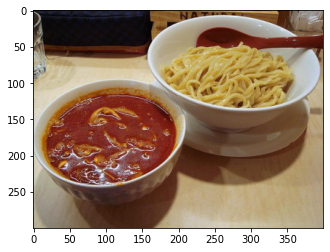

In [22]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("food100_supervised_train")
food100_supervised_val_metadata = MetadataCatalog.get("food100_supervised_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=food100_supervised_val_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())